# Tutorial for a gene expression error model with spike-ins, on simulated data

In [19]:
import pymc as pm
import arviz as az
#import bebi103

import numpy as np
import pandas as pd
import iqplot

import bokeh.io
import bokeh.plotting
from bokeh.layouts import gridplot
bokeh.io.output_notebook()

import colorcet

from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import row, column
from bokeh.models import Span, ColumnDataSource
from bokeh.layouts import gridplot

import matplotlib.pyplot as plt

from tqdm import tqdm

Loading BokehJS ...

# Model description
## No biological replicates

$$ \underset{\textcolor{purple}{\text{posterior}}}{\pi \left( \underline{\alpha}, \underline{b^{(x)}},\underline{b^{(s)}}, \mu_b, \sigma_b, \underline{x^{mRNA}}, X^{mRNA} | \underline{x^{seq}}, \underline{s^{seq}}, \underline{s^{spike}} \right)} \propto$$

$$\underset{\textcolor{purple}{\text{spike-in likelihood}}}{\pi \left(\underline{s^{spike}}, \underline{s^{seq}} | \underline{b^{(s)}} \right)}    \underset{\textcolor{purple}{\text{priors}}}{\pi \left(\underline{b^{(s)}} | \mu_b, \sigma_b \right)          \pi \left(\mu_b \right) \pi \left(\sigma_b \right)}\times$$

$$\underset{\textcolor{purple}{\text{txtome likelihood}}}{\pi \left(\underline{x^{seq}} | \underline{x^{mRNA}}, \underline{b^{(x)}} \right)}    \underset{\textcolor{purple}{\text{priors}}}{\pi \left(\underline{b^{(x)}} | \mu_b, \sigma_b \right)          }\times$$

$$ \underset{\textcolor{purple}{\text{idealized likelihood}}}{\pi \left( \underline{x^{mRNA}} | X^{mRNA}, \underline{\alpha}\right)}      \underset{\textcolor{purple}{\text{priors}}}{\pi \left(X^{mRNA} \right) \pi \left(\underline{\alpha} \right)}$$

# Generate simulated data

In [20]:
x_seq = np.array([500, 1, 10, 9000, 750, 2, 36962])


s_seq = np.array([4, 14, 175, 2875, 25678])
s_spike = np.array([2, 20, 200, 2000, 20000])

G = len(x_seq)
K = len(s_seq)

X_mrna_est = np.sum(x_seq)

betas = (x_seq / X_mrna_est)

# Run model

In [21]:
with pm.Model() as model:

    # spike-in/transcriptome priors
    mu_b = pm.HalfNormal('mu_b', sigma = 1)
    sigma_b = pm.LogNormal('sigma_b', mu = 0.5, sigma = 0.5)
    b_x = pm.LogNormal('b_x', mu = mu_b, sigma = sigma_b, shape = G)
    b_s = pm.LogNormal('b_s', mu = mu_b, sigma = sigma_b, shape = K)

    # idealized priors
    X_mrna = pm.Normal("X_mrna", mu = X_mrna_est, sigma = 2000)
    conc = pm.HalfNormal("conc", sigma = 50)
    alpha = pm.Dirichlet('alpha', a = conc * betas)

    # likelihood spike ins
    s_seq_obs = pm.Poisson('s_seq_obs', mu = s_spike * b_s, observed = s_seq)

    # likelihood transcriptome
    x_mrna = X_mrna * alpha
    x_seq_obs = pm.Poisson('x_seq_obs', mu = x_mrna * b_x, observed = x_seq)

    trace = pm.sample(1000, tune = 1000, target_accept = 0.90)
    prior_pred = pm.sample_prior_predictive(samples = 1000)
    ppc = pm.sample_posterior_predictive(trace)
    

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b, sigma_b, b_x, b_s, X_mrna, conc, alpha]


/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
Sampling: [X_mrna, alpha, b_s, b_x, conc, mu_b, s_seq_obs, sigma_b, x_seq_obs]
Sampling: [s_seq_obs, x_seq_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [22]:
az.summary(trace)

mean        sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
X_mrna    47131.122  1965.757  43518.142  50884.404     34.728   30.308   
mu_b          0.201     0.154      0.000      0.470      0.003    0.003   
sigma_b       0.565     0.212      0.232      0.956      0.006    0.005   
b_x[0]        1.373     0.875      0.295      2.713      0.020    0.052   
b_x[1]        1.518     1.414      0.180      3.336      0.035    0.138   
b_x[2]        1.551     1.741      0.182      3.346      0.045    0.238   
b_x[3]        1.063     0.219      0.665      1.446      0.004    0.005   
b_x[4]        1.311     0.733      0.355      2.491      0.016    0.035   
b_x[5]        1.511     1.295      0.167      3.240      0.027    0.099   
b_x[6]        1.000     0.064      0.882      1.117      0.001    0.001   
b_s[0]        1.613     0.671      0.532      2.812      0.011    0.015   
b_s[1]        0.790     0.185      0.446      1.125      0.003    0.003   
b_s[2]        0.882     0.067      0.760      1.010      0.001    0.001   
b_s[3]        1.437     0.026      1.389      1.486      0.000    0.000   
b_s[4]        1.284     0.008      1.269      1.299      0.000    0.000   
conc        104.605    33.457     45.350    168.166      0.486    0.548   
alpha[0]      0.010     0.005      0.002      0.020      0.000    0.000   
alpha[1]      0.000     0.000      0.000      0.000      0.000    0.000   
alpha[2]      0.000     0.000      0.000      0.000      0.000    0.000   
alpha[3]      0.187     0.036      0.120      0.255      0.001    0.001   
alpha[4]      0.015     0.007      0.004      0.028      0.000    0.000   
alpha[5]      0.000     0.000      0.000      0.000      0.000    0.000   
alpha[6]      0.788     0.036      0.718      0.854      0.001    0.001   

          ess_bulk  ess_tail  r_hat  
X_mrna      3221.0    3025.0    1.0  
mu_b        1779.0    1347.0    1.0  
sigma_b     1567.0    1976.0    1.0  
b_x[0]      2694.0    1965.0    1.0  
b_x[1]      2786.0    1840.0    1.0  
b_x[2]      2225.0    1554.0    1.0  
b_x[3]      2864.0    2604.0    1.0  
b_x[4]      2799.0    2353.0    1.0  
b_x[5]      2884.0    2476.0    1.0  
b_x[6]      2719.0    2859.0    1.0  
b_s[0]      3697.0    2736.0    1.0  
b_s[1]      3727.0    2652.0    1.0  
b_s[2]      5268.0    3003.0    1.0  
b_s[3]      4995.0    3025.0    1.0  
b_s[4]      6179.0    2967.0    1.0  
conc        4324.0    2406.0    1.0  
alpha[0]    2691.0    1974.0    1.0  
alpha[1]    2195.0    2082.0    1.0  
alpha[2]    2116.0    1758.0    1.0  
alpha[3]    2699.0    2583.0    1.0  
alpha[4]    2805.0    2211.0    1.0  
alpha[5]    2645.0    2150.0    1.0  
alpha[6]    2801.0    2700.0    1.0

# Prior predictive checks

In [23]:
prior_samples = prior_pred.prior_predictive['x_seq_obs'].values
plots = []

for i in range(G):
# for one gene
    gene_ind = i
    prior_gene = prior_samples[0,:,gene_ind]
    x_seq_gene = x_seq[gene_ind]
    #print(x_seq_gene)
    
    # set up histogram
    
    p1 = figure(title="Prior Predictive Check: gene " + str(gene_ind),
                 x_axis_label="x_seq_obs",
                 y_axis_label="Count",
                width = 400, height = 300,
                 background_fill_color="#fafafa")
    
    
    hist, edges = np.histogram(prior_gene, bins=100)
    
    p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
             fill_color="skyblue", line_color="white",
             legend_label="1000 random samples")
    
    p1.line(x = (x_seq_gene, x_seq_gene), y = (0,600), width = 3, color = 'black', line_dash = 'dotted')

    #p1.line(x = (prior_gene.max(), prior_gene.max()), y = (0, 600), color = 'purple')
    p1.x_range.end = x_seq_gene + 1000
    
    plots.append(p1)

n_cols = 4
# Split into rows
grid = [plots[i:i+n_cols] for i in range(0, len(plots), n_cols)]
# Display
show(gridplot(grid))

# Posterior predictive check - gene counts

In [24]:
post_samples = ppc.posterior_predictive['x_seq_obs'].values
post_samples_comb = post_samples.reshape(-1, post_samples.shape[2])
post_samples_comb.shape

plots = []

for i in range(G):
# for one gene
    gene_ind = i
    post_gene = post_samples_comb[:,gene_ind]
    x_seq_gene = x_seq[gene_ind]
    
    # set up histogram
    
    p1 = figure(title="posterior Predictive Check: counts of gene " + str(gene_ind),
                 x_axis_label="x_seq_obs",
                 y_axis_label="Count",
                width = 400, height = 300,
                 background_fill_color="#fafafa")
    
    
    hist, edges = np.histogram(post_gene, bins=100)
    
    p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
             fill_color="skyblue", line_color="white",
             legend_label="1000 random samples")
    
    p1.line(x = (x_seq_gene, x_seq_gene), y = (0,600), width = 3, color = 'black', line_dash = 'dotted')

    plots.append(p1)

n_cols = 4
# Split into rows
grid = [plots[i:i+n_cols] for i in range(0, len(plots), n_cols)]
# Display
show(gridplot(grid))

# Posterior predictive check - alpha

In [25]:
post_alpha = trace.posterior['alpha'].values
post_alpha_comb = post_alpha.reshape(-1, post_alpha.shape[2])

plots = []

for i in range(G):
# for one gene
    gene_ind = i
    post_gene = post_alpha_comb[:,gene_ind]
    alpha_gene = betas[gene_ind]
    
    # set up histogram
    
    p1 = figure(title="posterior Predictive Check: alpha of gene " + str(gene_ind),
                 x_axis_label="alpha",
                 y_axis_label="Count",
                width = 400, height = 300,
                 background_fill_color="#fafafa")
    
    
    hist, edges = np.histogram(post_gene, bins=100)
    
    p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
             fill_color="skyblue", line_color="white",
             legend_label="1000 random samples")
    
    p1.line(x = (alpha_gene, alpha_gene), y = (0,200), width = 3, color = 'black', line_dash = 'dotted')

    plots.append(p1)

n_cols = 4
# Split into rows
grid = [plots[i:i+n_cols] for i in range(0, len(plots), n_cols)]
# Display
show(gridplot(grid))

# Assess model quality

## Posterior traces

array([[<Axes: title={'center': 'mu_b'}>,
        <Axes: title={'center': 'mu_b'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>]], dtype=object)

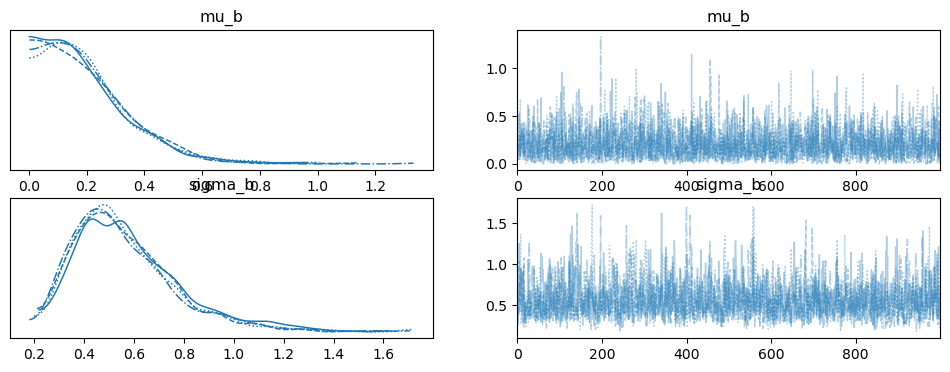

In [26]:
az.plot_trace(trace, var_names = ['mu_b', 'sigma_b'])

array([[<Axes: title={'center': 'X_mrna'}>,
        <Axes: title={'center': 'X_mrna'}>],
       [<Axes: title={'center': 'conc'}>,
        <Axes: title={'center': 'conc'}>]], dtype=object)

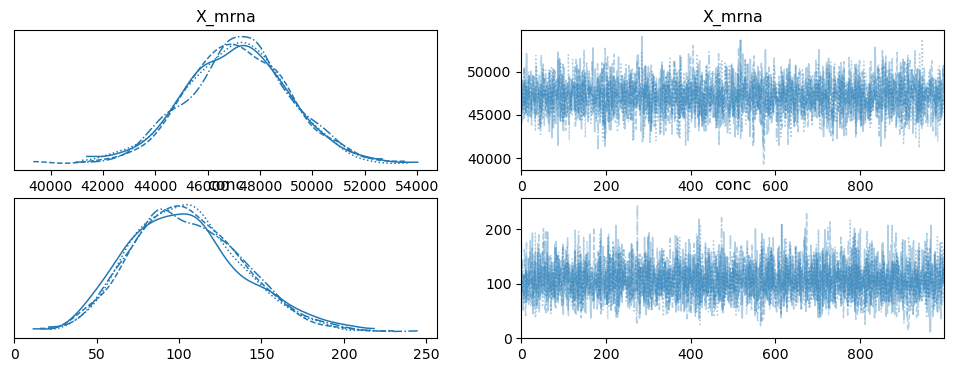

In [27]:
az.plot_trace(trace, var_names = ['X_mrna', 'conc'])

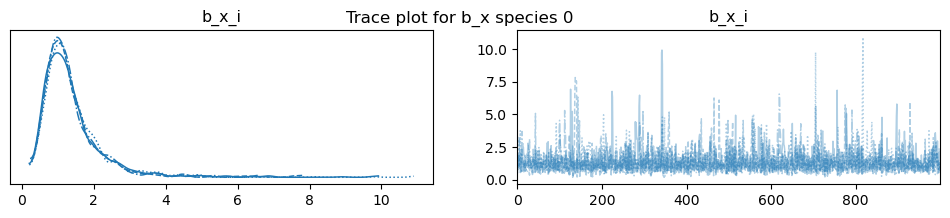

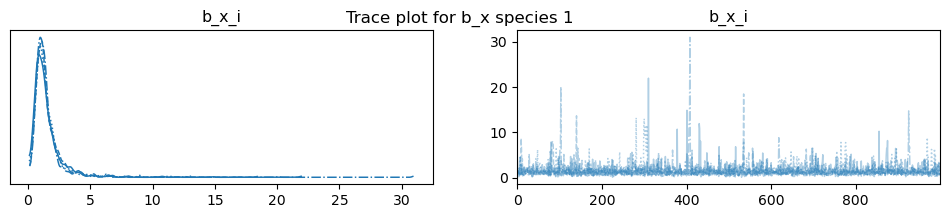

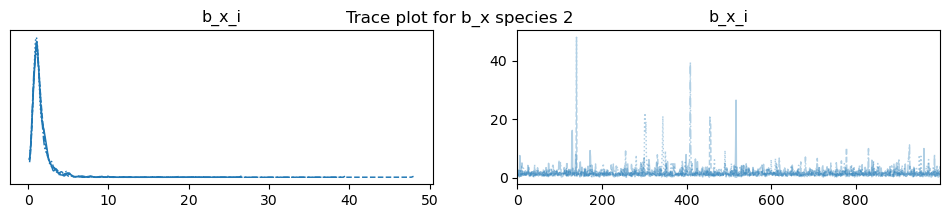

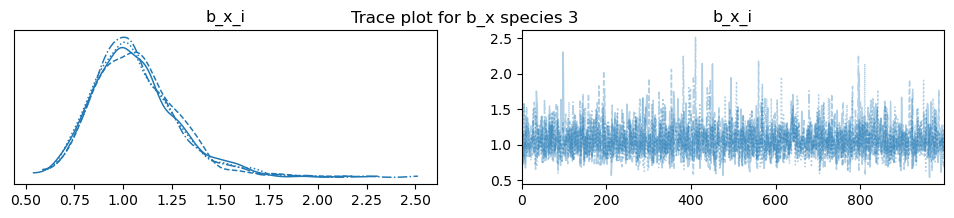

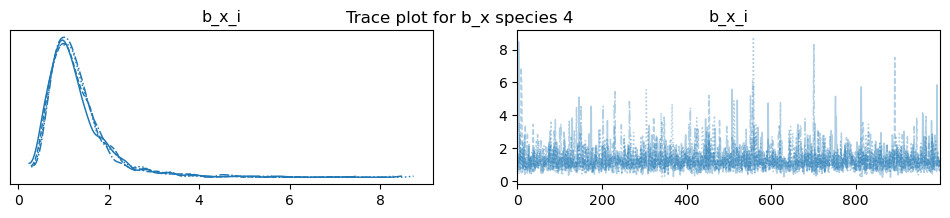

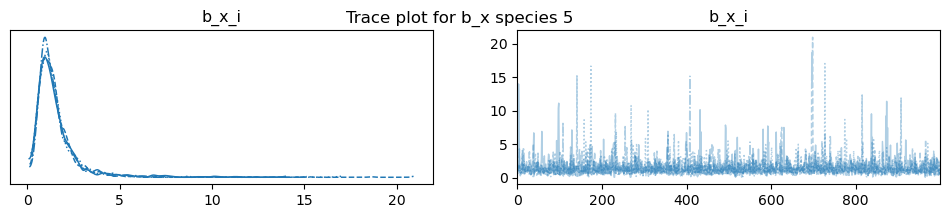

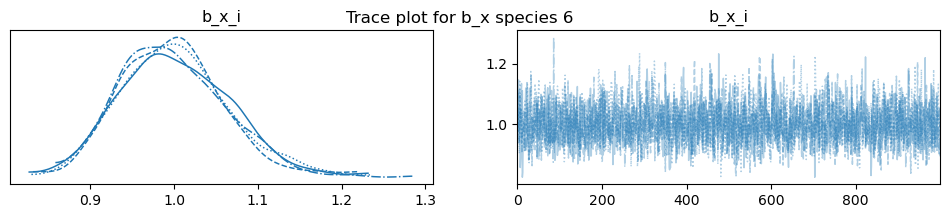

In [28]:
for i in range(G):
    var_name = f"b_x[{i}]"
    b_x_i = trace.posterior['b_x'].isel(b_x_dim_0=i).to_dataset(name='b_x_i')

    idata_i = trace.copy()
    idata_i.posterior = b_x_i

    az.plot_trace(idata_i, var_names=['b_x_i'])
    plt.suptitle(f"Trace plot for b_x species {i}")
    plt.show()

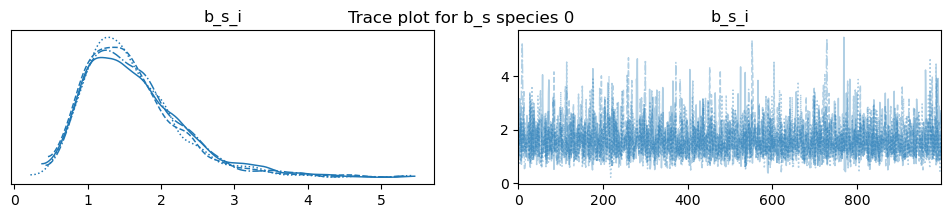

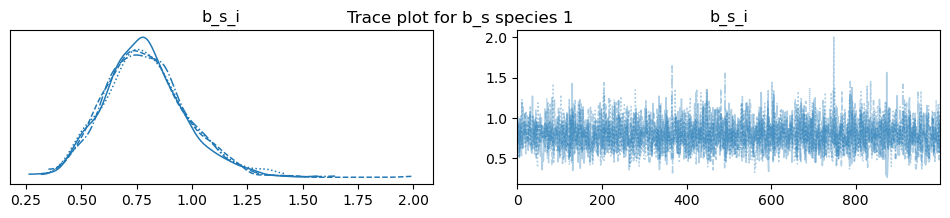

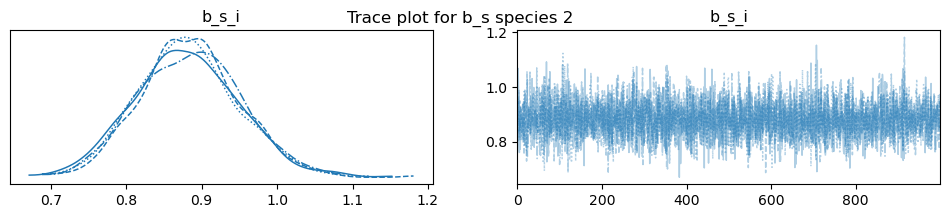

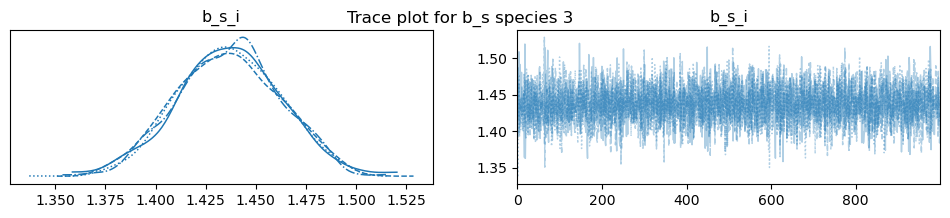

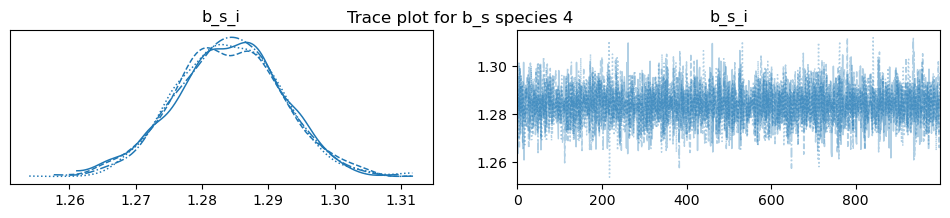

In [29]:
for i in range(K):
    var_name = f"b_s[{i}]"
    b_s_i = trace.posterior['b_s'].isel(b_s_dim_0=i).to_dataset(name='b_s_i')

    idata_i = trace.copy()
    idata_i.posterior = b_s_i

    az.plot_trace(idata_i, var_names=['b_s_i'])
    plt.suptitle(f"Trace plot for b_s species {i}")
    plt.show()

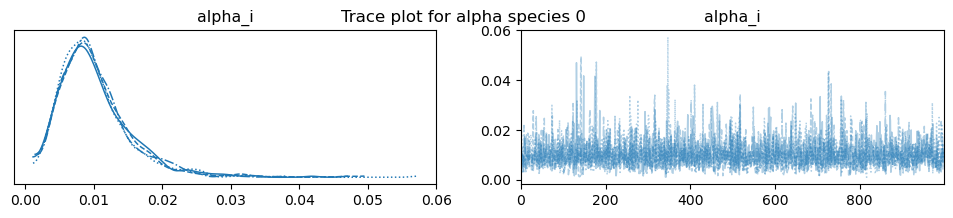

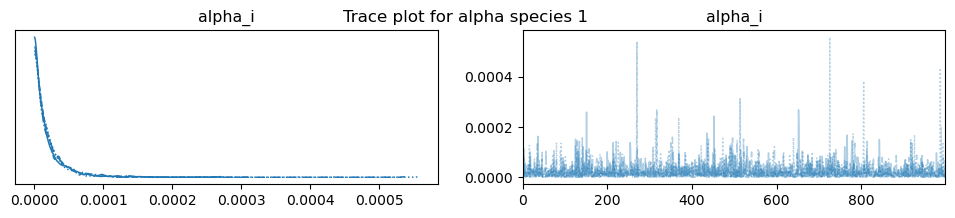

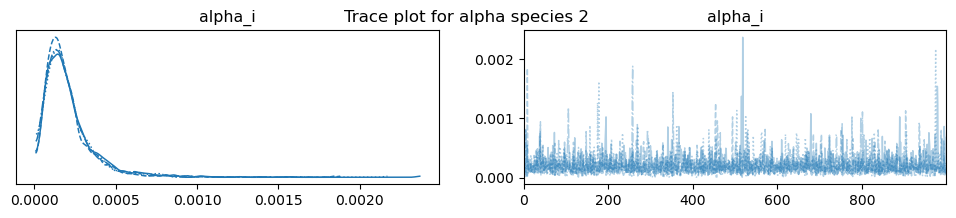

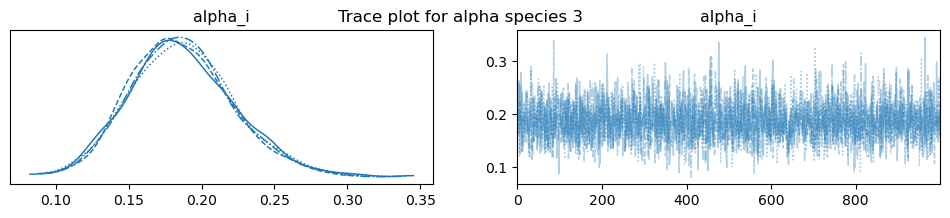

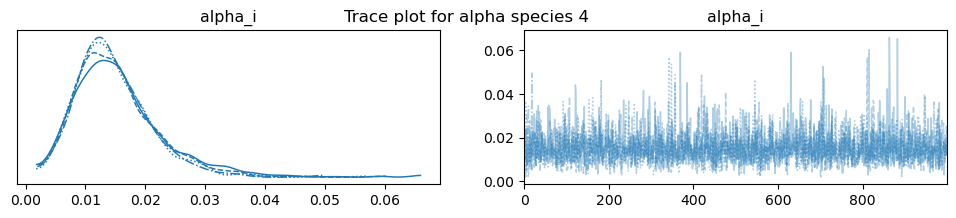

In [30]:
for i in range(K):
    var_name = f"alpha[{i}]"
    alpha_i = trace.posterior['alpha'].isel(alpha_dim_0=i).to_dataset(name='alpha_i')

    idata_i = trace.copy()
    idata_i.posterior = alpha_i

    az.plot_trace(idata_i, var_names=['alpha_i'])
    plt.suptitle(f"Trace plot for alpha species {i}")
    plt.show()

# nonidentifiability checks

### X_mrna vs b_x

array([[<Axes: ylabel='b_x\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='b_x\n1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='b_x\n2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='b_x\n3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='b_x\n4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='b_x\n5'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: xlabel='X_mrna', ylabel='b_x\n6'>,
        <Axes: xlabel='b_x\n0'>, <Axes: xlabel='b_x\n1'>,
        <Axes: xlabel='b_x\n2'>, <Axes: xlabel='b_x\n3'>,
        <Axes: xlabel='b_x\n4'>, <Axes: xlabel='b_x\n5'>]], dtype=object)

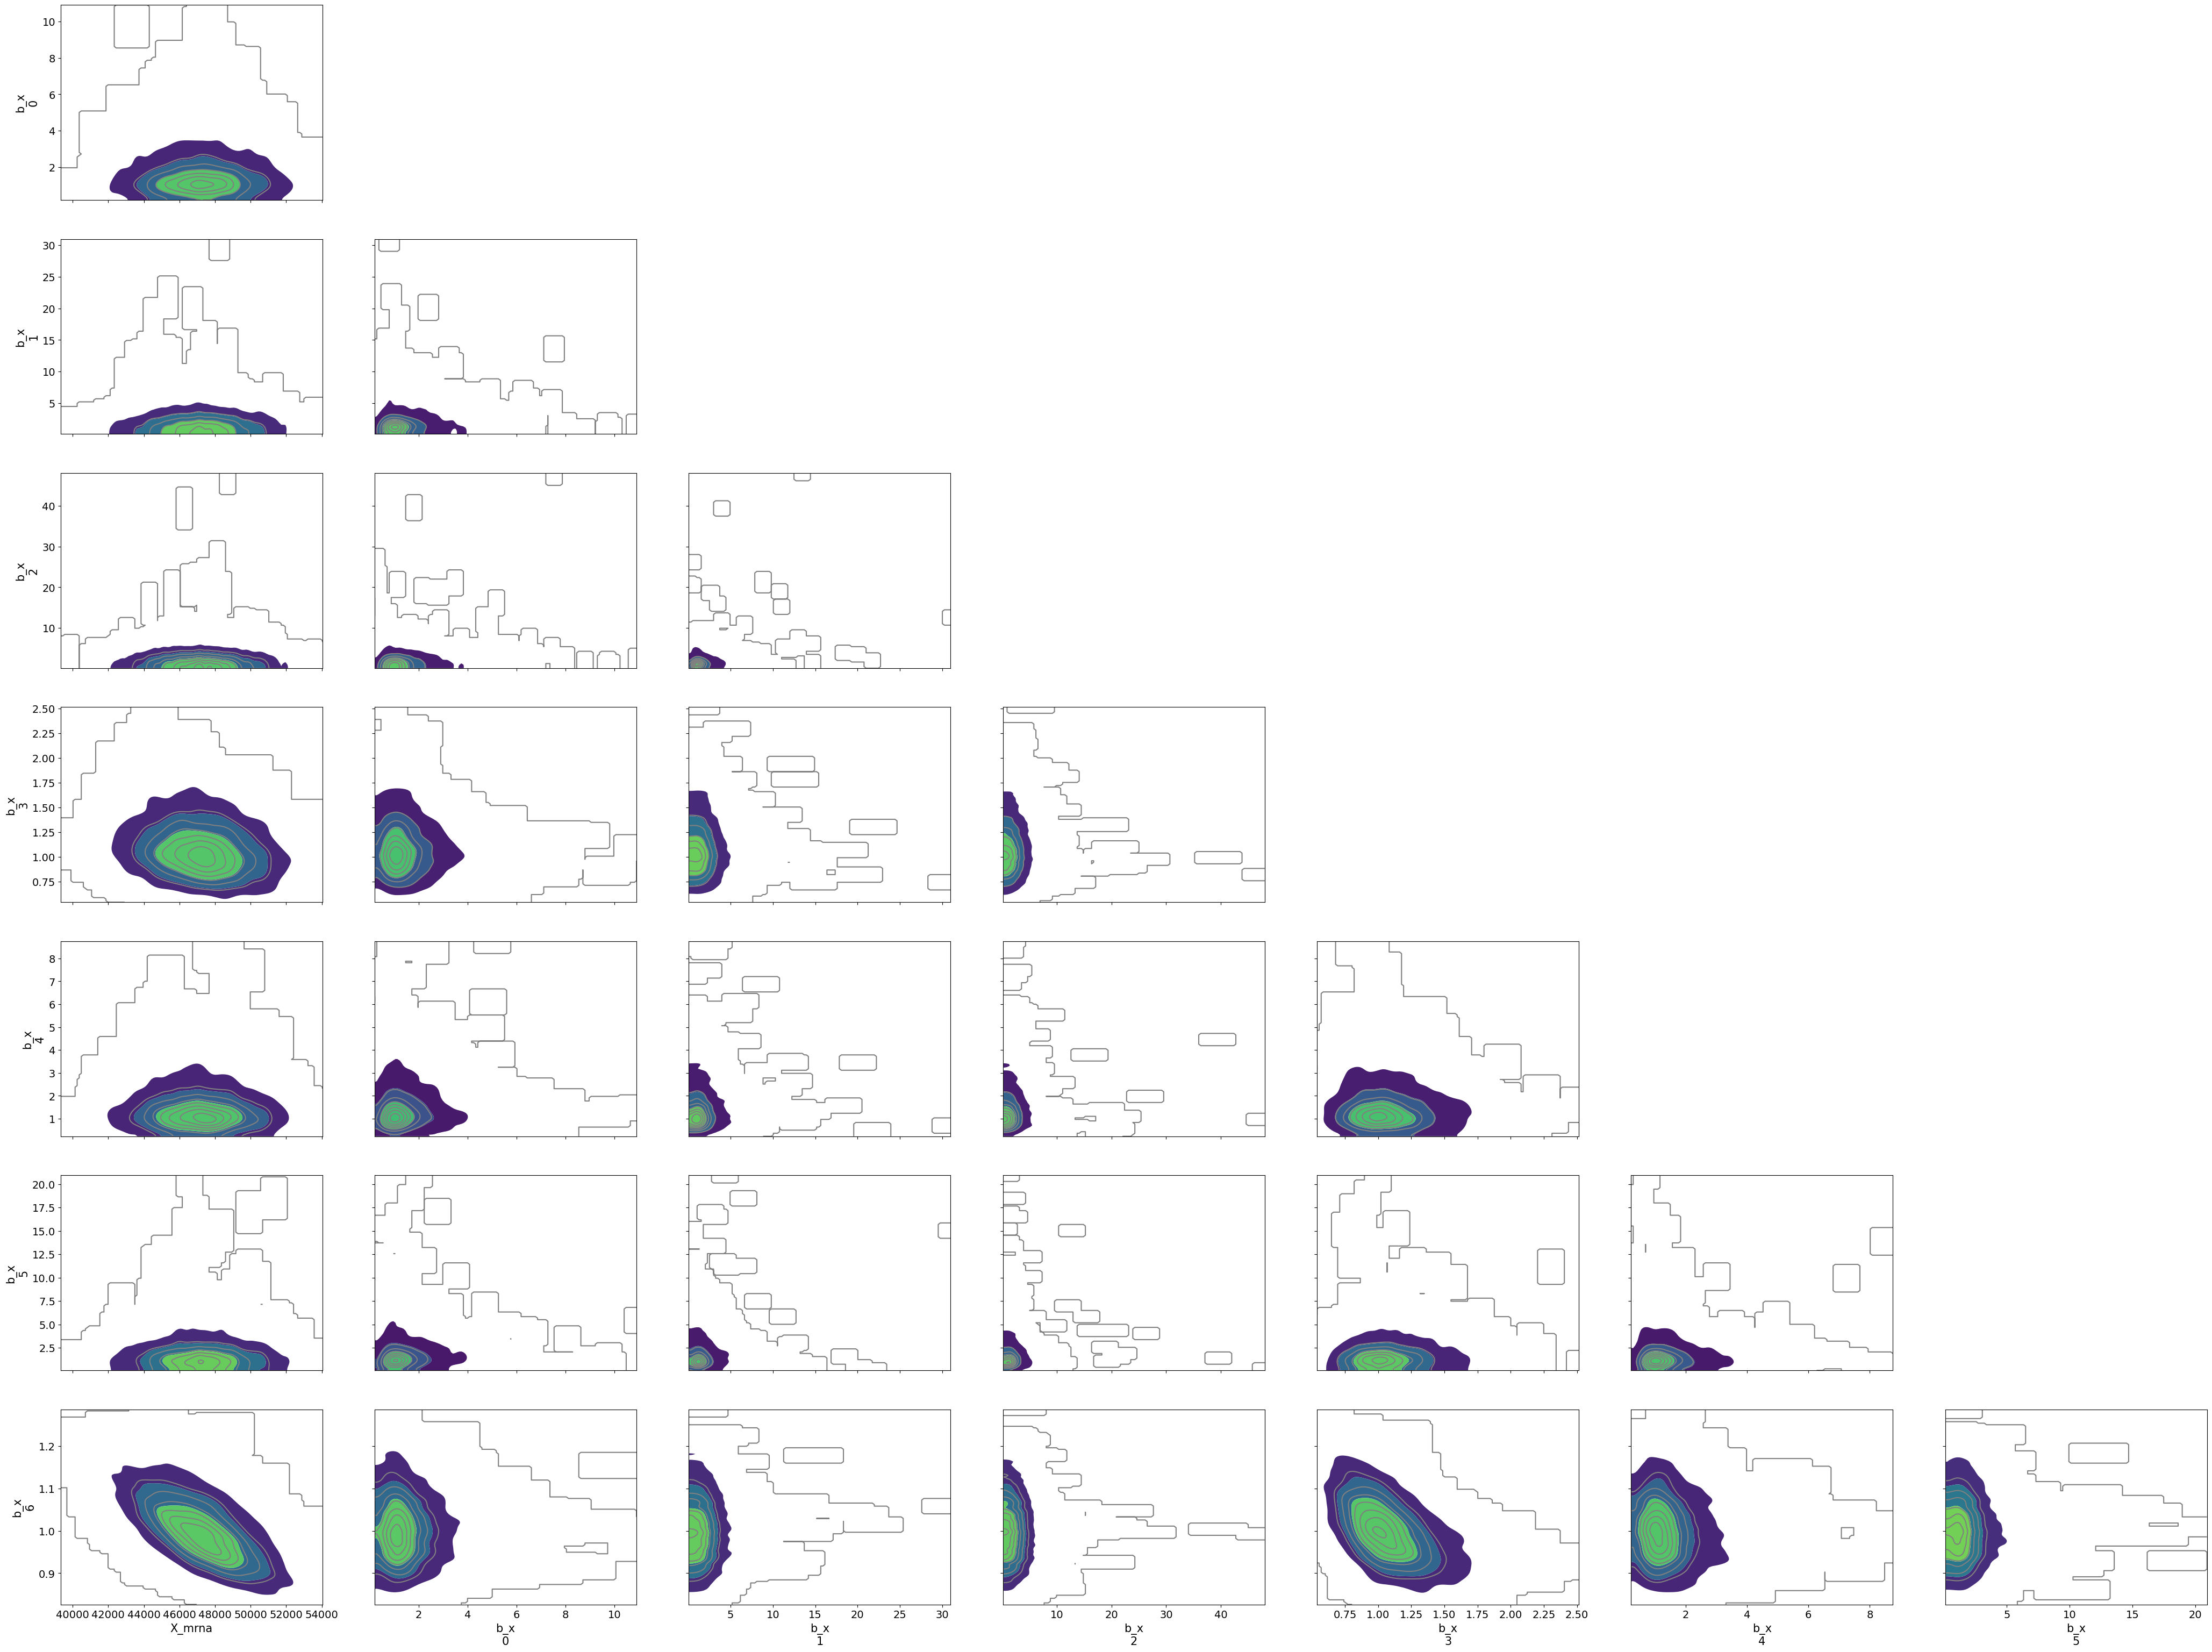

In [31]:
az.plot_pair(trace, var_names = [ 'X_mrna', 'b_x',], kind = 'kde')

### X_mrna vs alpha

array([[<Axes: ylabel='alpha\n0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n1'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n2'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n3'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n4'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n5'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='X_mrna', ylabel='alpha\n6'>,
        <Axes: xlabel='alpha\n0'>, <Axes: xlabel='alpha\n1'>,
        <Axes: xlabel='alpha\n2'>, <Axes: xlabel='alpha\n3'>,
        <Axes: xlabel='alpha\n4'>, <Axes: xlabel='alpha\n5'>]],
      dtype=object)

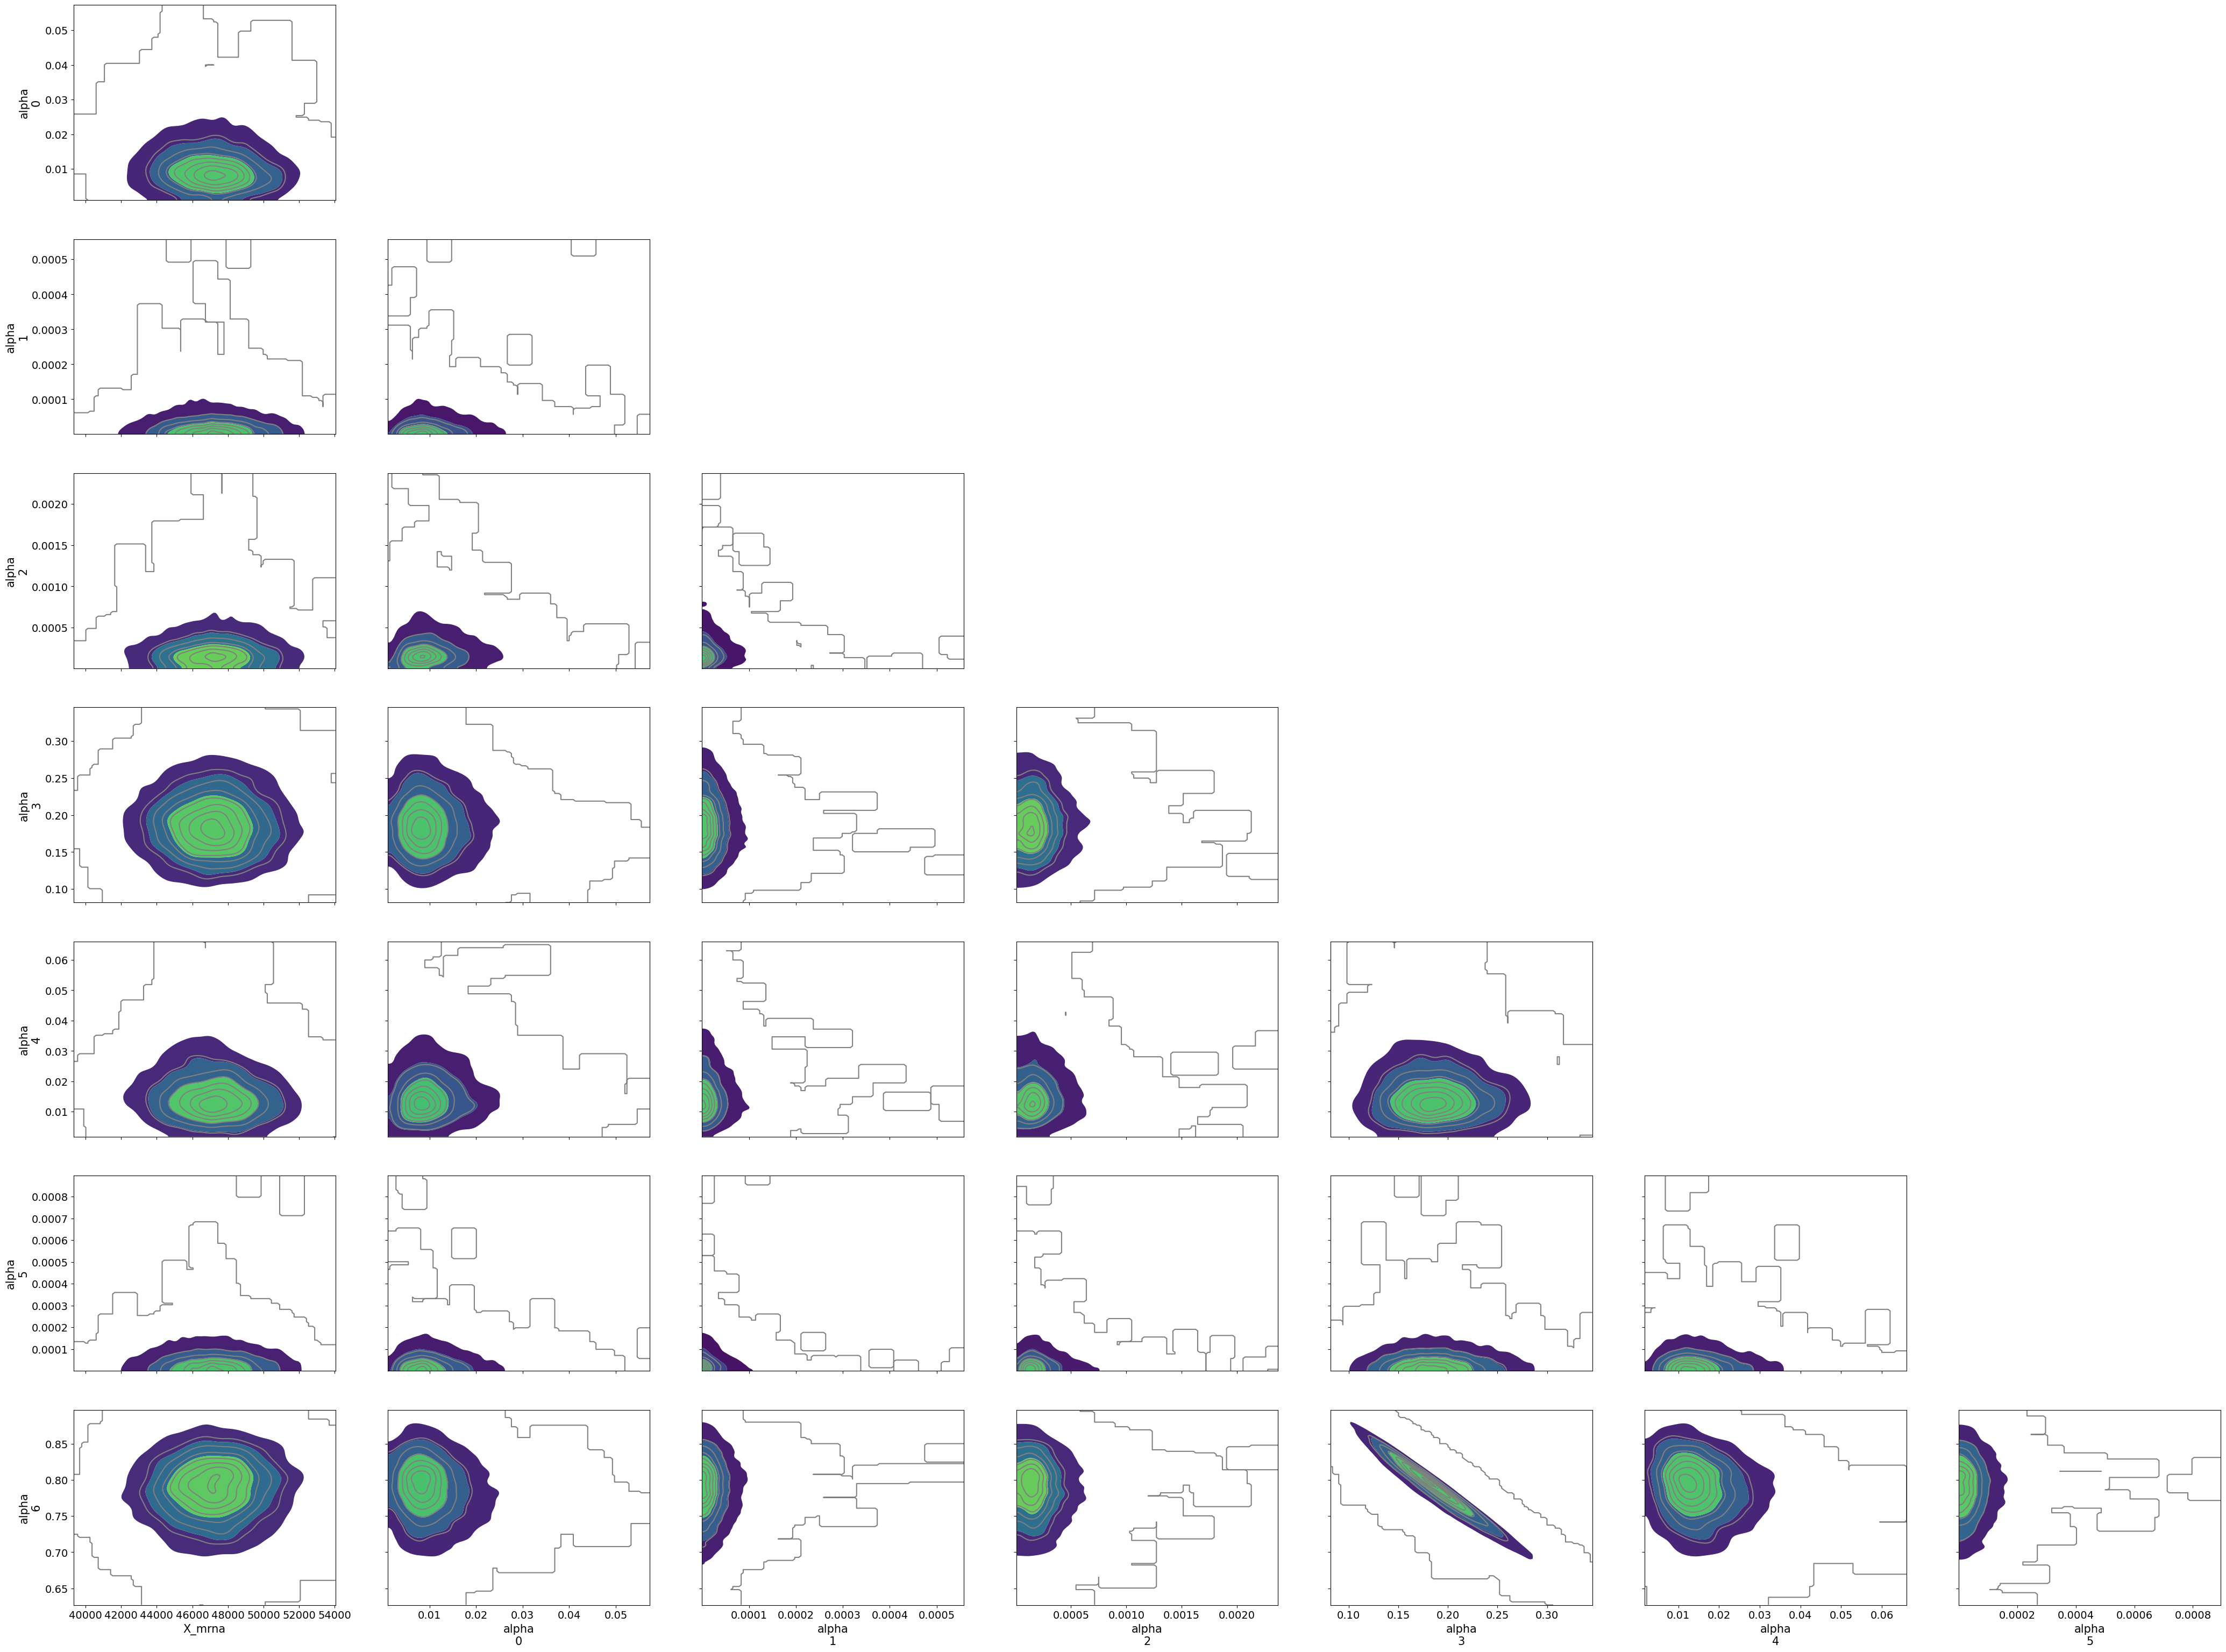

In [32]:
az.plot_pair(trace, var_names = [ 'X_mrna', 'alpha'], kind = 'kde')

### alpha vs b_x
(pairwise)

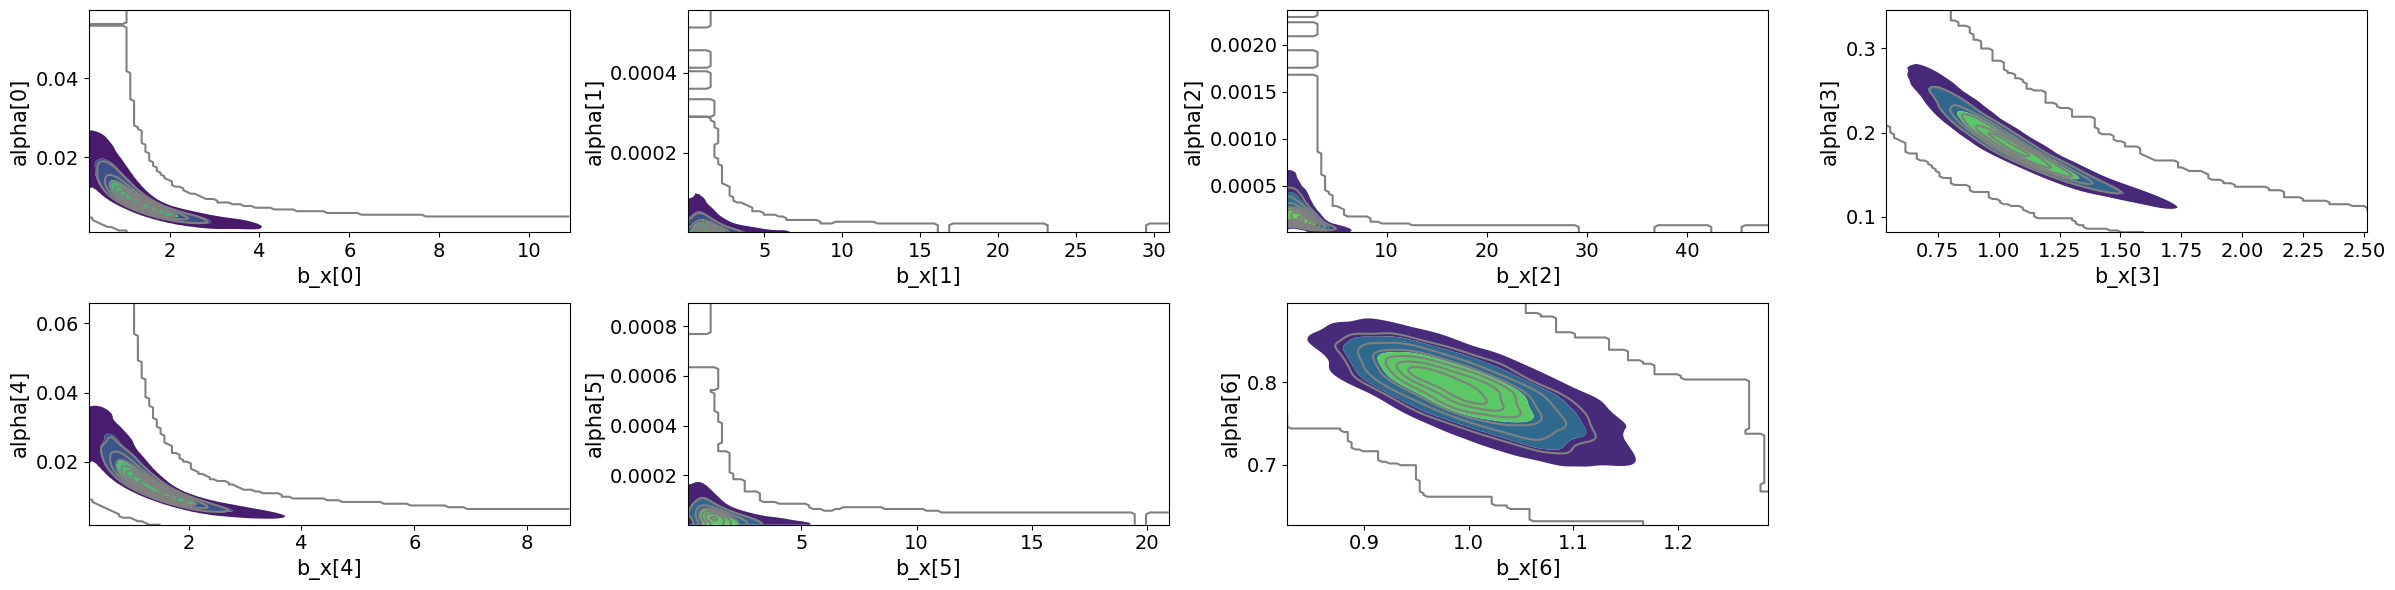

In [33]:
ncols = 4
nrows = (G + ncols - 1) // ncols  # ceiling division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 3*nrows))
axes = axes.flatten()

for i in range(G):
    b_x_i = trace.posterior['b_x'].isel(b_x_dim_0=i)
    alpha_i = trace.posterior['alpha'].isel(alpha_dim_0=i)

    az.plot_pair({'b_x[{}]'.format(i): b_x_i, 'alpha[{}]'.format(i): alpha_i}, kind='kde', ax=axes[i])

# Hide unused subplots if any
for j in range(G, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### alpha vs b_s

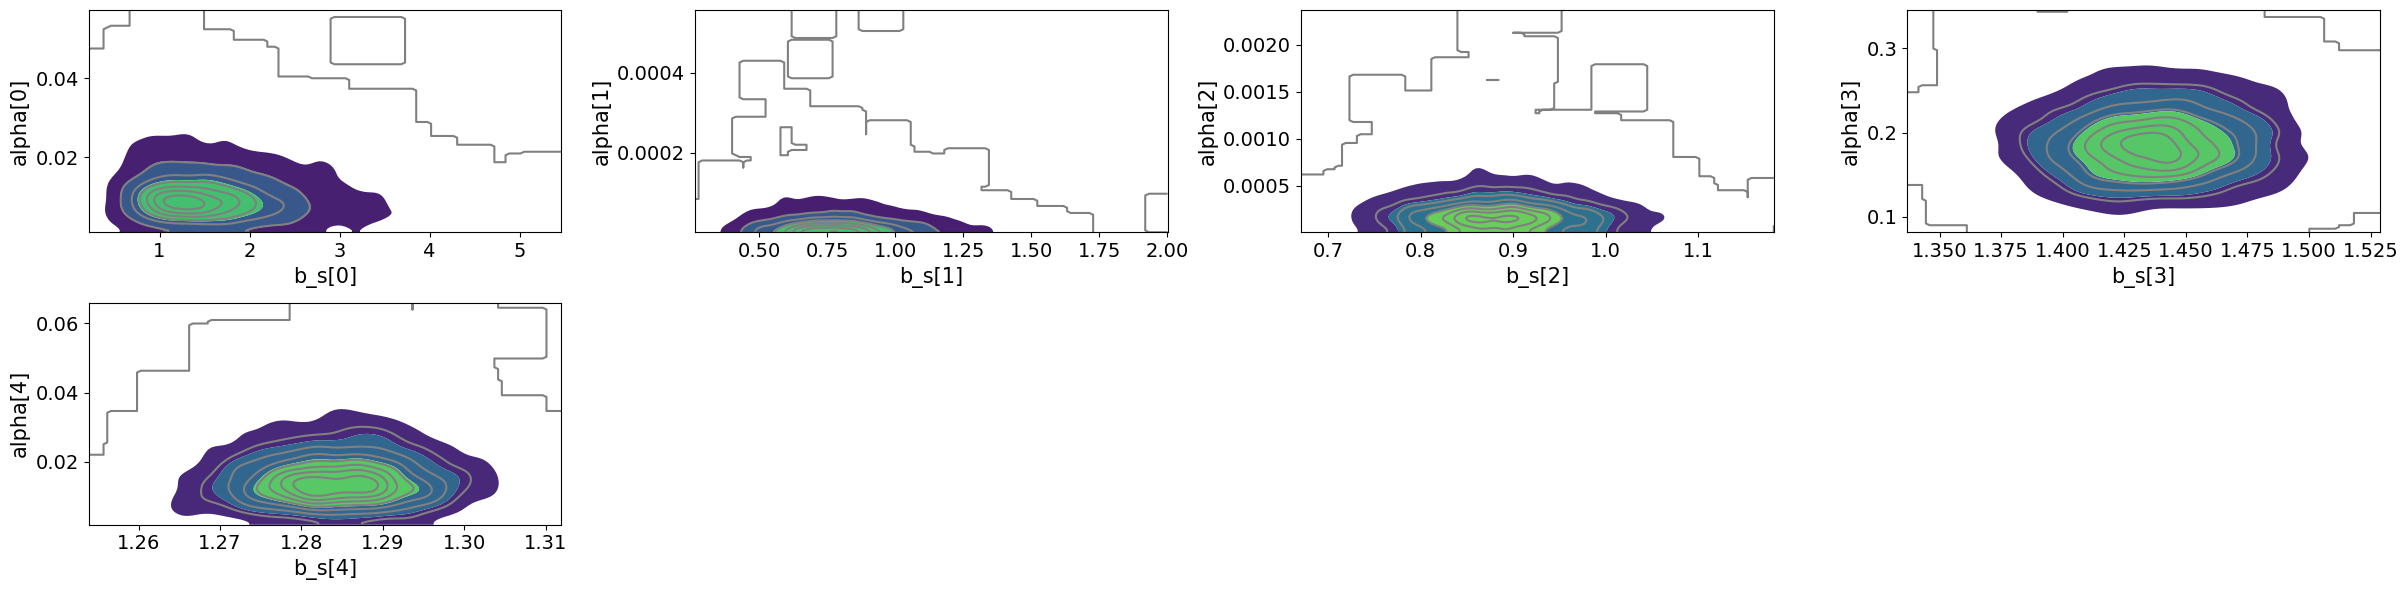

In [34]:
ncols = 4
nrows = (K + ncols - 1) // ncols  # ceiling division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 3*nrows))
axes = axes.flatten()

for i in range(K):
    b_s_i = trace.posterior['b_s'].isel(b_s_dim_0=i)
    alpha_i = trace.posterior['alpha'].isel(alpha_dim_0=i)

    az.plot_pair({'b_s[{}]'.format(i): b_s_i, 'alpha[{}]'.format(i): alpha_i}, kind='kde', ax=axes[i])

# Hide unused subplots if any
for j in range(K, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### X_mrna vs b_s

array([[<Axes: ylabel='b_s\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='b_s\n1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='b_s\n2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='b_s\n3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='X_mrna', ylabel='b_s\n4'>,
        <Axes: xlabel='b_s\n0'>, <Axes: xlabel='b_s\n1'>,
        <Axes: xlabel='b_s\n2'>, <Axes: xlabel='b_s\n3'>]], dtype=object)

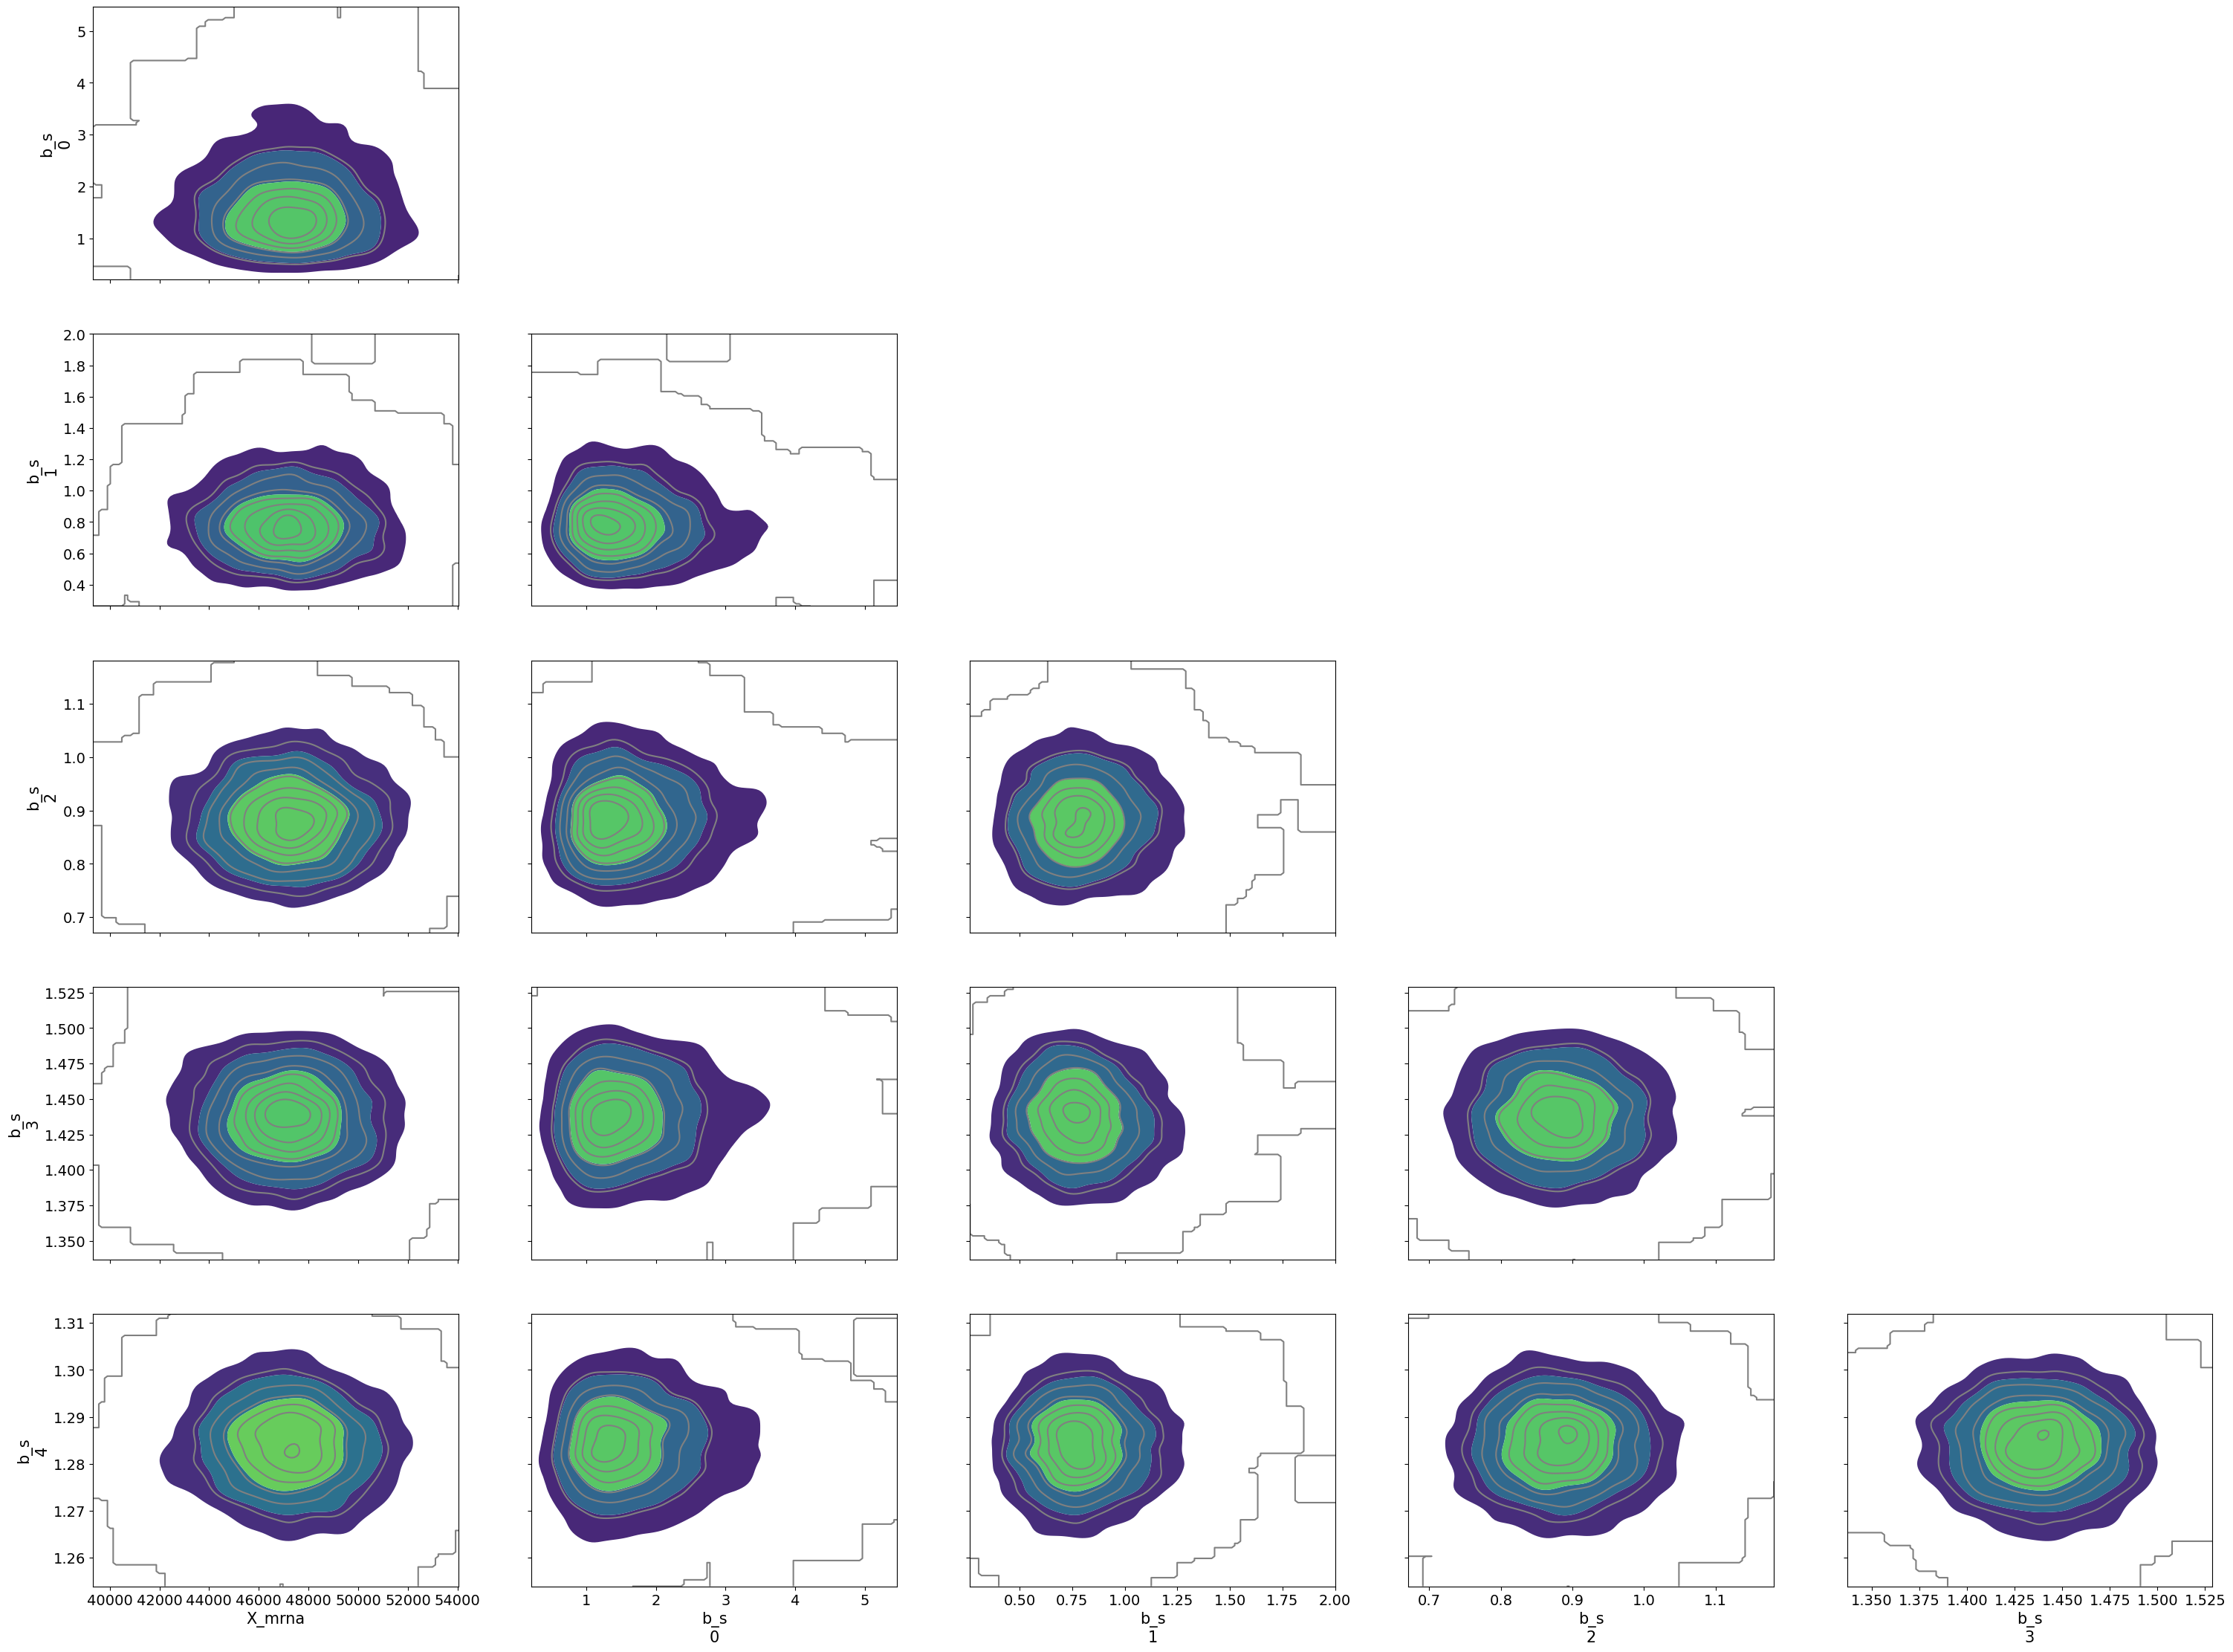

In [35]:
az.plot_pair(trace, var_names = [ 'X_mrna', 'b_s',], kind = 'kde')

* there are still identifiability issues with alpha and b_x

* did we even learn anything from b_s? is b_x different?

changing spike in values does change b_s and alpha slightly

alpha distributions are slightly different

still nonidentifiability tho

In [36]:
%load_ext watermark
%watermark -v -p numpy,bokeh,pymc,arviz,bebi103,iqplot,pandas,matplotlib,colorcet,tqdm,jupyterlab

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.30.0

numpy     : 1.26.4
bokeh     : 3.7.3
pymc      : 5.19.1
arviz     : 0.21.0
bebi103   : 0.1.26
iqplot    : 0.3.7
pandas    : 2.2.3
matplotlib: 3.9.4
colorcet  : 3.1.0
tqdm      : 4.67.1
jupyterlab: 4.3.3

